In [1]:
from src.esn import ESN
from src.utils import config, helper
import src.conceptors as conceptors

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import itertools
from typing import NamedTuple

In [4]:
import os
import json
import pickle as pkl

In [5]:
prng = np.random.default_rng(1234)

# Setup hyperparameters
Use configurations from `src/utils/config.py` and set the configuration values to be lists of all the hyperparameters that you want to try. 

In [6]:
esnConfigs = config.ESNConfig(
    input_size=1,
    reservoir_size=100,
    output_size=1,
    feedback=False,
    spectral_radius=[1.2, 1.5],
    init_weights='normal',
    init_weights_b='normal',
    init_weights_in='normal',
    init_weights_density=0.2,
    init_weights_in_density=1.0,
    init_weights__args={'loc': 0., 'scale': 1.},
    init_weights_b__args={'loc': 0., 'scale': 0.2},
    init_weights_in__args={'loc': 0., 'scale': 1.5},
)
trainingConfigs = config.TrainingConfig(
    washout=100,
    optimizer_wout_alpha=1e-3,
    compute_conceptor='compute_conceptor',
    compute_loading='loading_ridge_report',
    init_states='uniform',  # TODO: allow to make this zero (i.e. constant)?
    init_states__args={'low': -1., 'high': 1.},
    optimizer_wout__args={},
    compute_loading__args=[
        {'regularizer': reg_loading} for reg_loading in 
        [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
        # [1e-5, 5e-5, 1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3]
    ],
    compute_conceptor__args=[
        {'aperture': aperture} for aperture in 
        [1., 10., 20.]
        # [0.5, 1., 2.5, 5., 10., 15., 20.]
    ]
)

Turn this into a list of valid configurations (basically a Cartesian product).

In [6]:
def configsToConfigsList(configs: NamedTuple):
    configsDict = {k: v for k, v in configs._asdict().items() if isinstance(v, list)}
    configChoices = itertools.product(*configsDict.values())
    return [
        configs._replace(**{
            key: configChoice[idx] for idx, key in enumerate(configsDict)
        })
        for configChoice in configChoices
    ]

In [8]:
esnConfigsList = configsToConfigsList(esnConfigs)
trainingConfigsList = configsToConfigsList(trainingConfigs)
# for convenience (to avoid a nested for loop)
configsList = list(itertools.product(esnConfigsList, trainingConfigsList))
len(configsList)

30

# Run Hyperparameter Search

Run the whole procedure for every choice of hyperparameters, saving all the necessary data (for later analysis).

In [9]:
T_pattern = 2500
ut = np.array([
    helper.n_periodic(4, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(4, T_pattern, np.random.default_rng(42)),
    helper.n_sine(8.83, T_pattern, phase=0.25),
    helper.n_sine(9.83, T_pattern, phase=0.)
])

Make folder to save data into

In [10]:
foldername = 'data/experiments/1031_hyperparam_search'
os.makedirs(foldername)
with open(os.path.join(foldername, 'configs.json'), 'w') as f:
    json.dump({
        'esnConfigs': esnConfigs._asdict(),
        'trainingConfigs': trainingConfigs._asdict()
    }, f, indent=4)

In [11]:
# # mirror: load configurations
# with open(os.path.join(foldername, 'configs.json'), 'r') as f:
#     d = json.load(f)
#     esnConfigs = config.ESNConfig(**d['esnConfigs'])
#     trainingConfigs = config.TrainingConfig(**d['trainingConfigs'])

In [12]:
np.save(os.path.join(foldername, 'ut.npy'), ut)

In [13]:
# # mirror: load input
# ut = np.load(os.path.join(foldername, 'ut.npy'))

Run the experiments

In [14]:
def pipeline(prng, ut, esnConfig, trainingConfig: config.TrainingConfig):
    """
    Trains ESN on identity function.

    :param key: PRNG generator
    :param ut: input patterns, of shape (P, T, L)
        P: number of patterns
        T: number of timesteps for each pattern
        L: number of input dimensions
    :param esn_config: ESNConfig tuple
    :param config: TrainingConfig tuple
    """
    esn = ESN(esnConfig, prng)
    _, maxT, _ = ut.shape
    N = esnConfig.reservoir_size

    # pass each pattern through network
    # xt: (P, T, N), yt: (P, T, M)
    xt, yt = map(np.array, (zip(*map(esn.harvest_states, ut))))  # TODO: move >> ESN.batch_harvest
    # concatenate patterns along time
    X = np.concatenate(xt[:, trainingConfig.washout:, :], axis=0)
    U = np.concatenate(ut[:, trainingConfig.washout:, :], axis=0)

    # desired output = input
    Y_T = U.copy()

    # compute output weights
    esn.update_weights(X, U, Y_T, alpha=trainingConfig.optimizer_wout_alpha,
                       **trainingConfig.optimizer_wout__args)
    # harvest trained states and outputs
    xt_trained, yt_trained = map(np.array, (zip(*map(esn.harvest_states, ut))))

    # load the weight matrix (need shifted X_tilde and B)
    X_ = np.concatenate(xt[:, trainingConfig.washout-1: maxT-1, :])
    B = np.repeat(esn.b, X_.shape[0], axis=1).T
    compute_loading = getattr(conceptors, trainingConfig.compute_loading)
    W_loaded = compute_loading(X, X_, B, **trainingConfig.compute_loading__args)
    W_before_loading = esn.w.copy()
    esn.w = W_loaded.copy()

    # compute conceptor
    compute_conceptor = getattr(conceptors, trainingConfig.compute_conceptor)
    xt_loaded, yt_loaded = map(np.array, (zip(*map(esn.harvest_states, ut))))
    Ci = [
        compute_conceptor(xt_loaded_i[trainingConfig.washout:, :],
                          **trainingConfig.compute_conceptor__args)
        for xt_loaded_i in xt_loaded
    ]

    # get initial reservoir state # TODO: do this for other forward passes too?
    try:
        # if random (e.g. uniform, normal)
        x_init_fun = getattr(prng, trainingConfig.init_states)
        x_init = x_init_fun(**trainingConfig.init_states__args, size=(N, 1))
    except AttributeError:
        # if constant (e.g. ones, zeros)
        x_init_fun = getattr(np, trainingConfig.init_states)
        x_init = x_init_fun(shape=(N, 1), **trainingConfig.init_states__args)

    # test the loaded reservoir with the conceptor
    xt_conceptor, yt_conceptor = [], []
    for i in range(len(ut)):
        xt_tmp, yt_tmp = esn.harvest_states(np.zeros_like(ut[i]), 
                                            x_init=x_init.copy(), C=Ci[i])
        xt_conceptor.append(xt_tmp)
        yt_conceptor.append(yt_tmp)
    xt_conceptor = np.array(xt_conceptor)
    yt_conceptor = np.array(yt_conceptor)

    return {
        'xt': xt, 
        'yt': yt,
        'xt_trained': xt_trained,
        'yt_trained': yt_trained,
        'xt_loaded': xt_loaded,
        'yt_loaded': yt_loaded,
        'xt_conceptor': xt_conceptor,
        'yt_conceptor': yt_conceptor,
        'W_before_loading': W_before_loading,
        'esn': esn
    }

In [15]:
print(f'Starting experiments. Total number: {len(configsList)}')
for idx, (esnConfig, trainingConfig) in enumerate(configsList):
    print('Running experiment {:3}/{:3}'.format(
        idx+1, len(configsList)
    ))
    # save hyperparameters to file
    with open(os.path.join(foldername, f'exp{idx}.json'), 'w') as f:
        json.dump({
            'esnConfig': esnConfig._asdict(),
            'trainingConfig': trainingConfig._asdict()
        }, f, indent=4)
    # run pipeline
    data = pipeline(prng, ut, esnConfig, trainingConfig)
    # save data to file
    for key, obj in data.items():
        if key == 'esn':
            with open(os.path.join(foldername, f'exp{idx}_esn.pkl'), 'wb') as f:
                pkl.dump(obj, f)
        else:
            np.save(os.path.join(foldername, f'exp{idx}_{key}.npy'), obj)

Starting experiments. Total number: 30
Running experiment   1/ 30
Running experiment   2/ 30
Running experiment   3/ 30
Running experiment   4/ 30
Running experiment   5/ 30
Running experiment   6/ 30
Running experiment   7/ 30
Running experiment   8/ 30
Running experiment   9/ 30
Running experiment  10/ 30
Running experiment  11/ 30
Running experiment  12/ 30
Running experiment  13/ 30
Running experiment  14/ 30
Running experiment  15/ 30
Running experiment  16/ 30
Running experiment  17/ 30
Running experiment  18/ 30
Running experiment  19/ 30
Running experiment  20/ 30
Running experiment  21/ 30
Running experiment  22/ 30
Running experiment  23/ 30
Running experiment  24/ 30
Running experiment  25/ 30
Running experiment  26/ 30
Running experiment  27/ 30
Running experiment  28/ 30
Running experiment  29/ 30
Running experiment  30/ 30


# Plotting the results


In [7]:
foldername = 'data/experiments/1031_hyperparam_search'

In [8]:
PATTERN_IDX = 0

In [9]:
# load configurations from file
with open(os.path.join(foldername, 'configs.json'), 'r') as f:
    d = json.load(f)
    esnConfigs = config.ESNConfig(**d['esnConfigs'])
    trainingConfigs = config.TrainingConfig(**d['trainingConfigs'])
# convert configurations into lists (as done above)
esnConfigsList = configsToConfigsList(esnConfigs)
trainingConfigsList = configsToConfigsList(trainingConfigs)
configsList = list(itertools.product(esnConfigsList, trainingConfigsList))

In [10]:
# load input already
ut = np.load(os.path.join(foldername, 'ut.npy'))

Overview plots:
- performance comparison for different parameters (choose X, Y, Z, color - one of which is performance) where performance is computed phase-invariantly
- time series state/output plot for 2D grid of hyperparams 

Detailed plots:
- Time series plots of states and outputs

In [11]:
from ipywidgets import interact, widgets

In [12]:
esnHyper = [k for k, v in esnConfigs._asdict().items() if isinstance(v, list)]
trainHyper = [k for k, v in trainingConfigs._asdict().items() if isinstance(v, list)]
hypers = esnHyper + trainHyper
hypers

['spectral_radius', 'compute_conceptor__args', 'compute_loading__args']

First, we need to choose a base configuration. This will set up all the hyperparameters that will not be sweeped in the plot. 

In [13]:
esnBaseConfig = config.ESNConfig(
    input_size=1,
    reservoir_size=100,
    output_size=1,
    feedback=False,
    spectral_radius=1.5,  # this can be sweeped
    init_weights='normal',
    init_weights_b='normal',
    init_weights_in='normal',
    init_weights_density=0.2,
    init_weights_in_density=1.0,
    init_weights__args={'loc': 0., 'scale': 1.},
    init_weights_b__args={'loc': 0., 'scale': 0.2},
    init_weights_in__args={'loc': 0., 'scale': 1.5},
)
trainBaseConfig = config.TrainingConfig(
    washout=100,
    optimizer_wout_alpha=1e-3,
    compute_conceptor='compute_conceptor',
    compute_loading='loading_ridge_report',
    init_states='uniform',
    init_states__args={'low': -1., 'high': 1.},
    optimizer_wout__args={},
    compute_loading__args={'regularizer': 1e-1},  # this can be sweeped
    compute_conceptor__args={'aperture': 20.}  # this can be sweeped
)

## 2D Grid of time series plots

In [14]:
def namedtuple_safe_replace(obj: NamedTuple, d: dict):
    return obj._replace(**{
        k: v for k, v in d.items() if k in obj._asdict().keys()
    })

In [15]:
def timeseriesPlot2d(hyperparameter1, hyperparameter2, t_min=200, t_max=220, 
                data='yt_conceptor', figsize=None, esnBaseConfig=esnBaseConfig, 
                trainBaseConfig=trainBaseConfig, ut=ut, esnConfigs=esnConfigs, 
                trainingConfigs=trainingConfigs, configsList=configsList):
    hyper1esn = hyperparameter1 in esnBaseConfig._asdict().keys()
    hyper2esn = hyperparameter2 in esnBaseConfig._asdict().keys()
    hyper1vals = (esnConfigs if hyper1esn else trainingConfigs)._asdict()[hyperparameter1]
    hyper2vals = (esnConfigs if hyper2esn else trainingConfigs)._asdict()[hyperparameter2]
    fig, axs = plt.subplots(nrows=len(hyper1vals), ncols=len(hyper2vals),
                            sharex=True, sharey=True, figsize=figsize)
    for idx1, hyper1val in enumerate(hyper1vals):
        for idx2, hyper2val in enumerate(hyper2vals):
            ax = axs[idx1, idx2]
            esnConfig = namedtuple_safe_replace(esnBaseConfig, {
                hyperparameter1: hyper1val,
                hyperparameter2: hyper2val
            })
            trainConfig = namedtuple_safe_replace(trainBaseConfig, {
                hyperparameter1: hyper1val,
                hyperparameter2: hyper2val
            })
            experimentIdx = configsList.index((esnConfig, trainConfig))

            timeseries = np.load(os.path.join(foldername, f'exp{experimentIdx}_{data}.npy'))
            if idx1 == 0:
                if isinstance(hyper2val, dict):
                    ax.set_title(', '.join(map(str, hyper2val.values())))
                else:
                    ax.set_title(f'{hyper2val}')
            if idx2 == 0:
                if isinstance(hyper1val, dict):
                    ax.set_ylabel(', '.join(map(str, hyper1val.values())))
                else:
                    ax.set_ylabel(f'{hyper1val}')
            ax.plot(ut[PATTERN_IDX, t_min:t_max, :], ls='--')
            ax.plot(timeseries[PATTERN_IDX, t_min:t_max, :])
    fig.suptitle(f'{hyperparameter2}')
    fig.supylabel(f'{hyperparameter1}')
    plt.tight_layout()

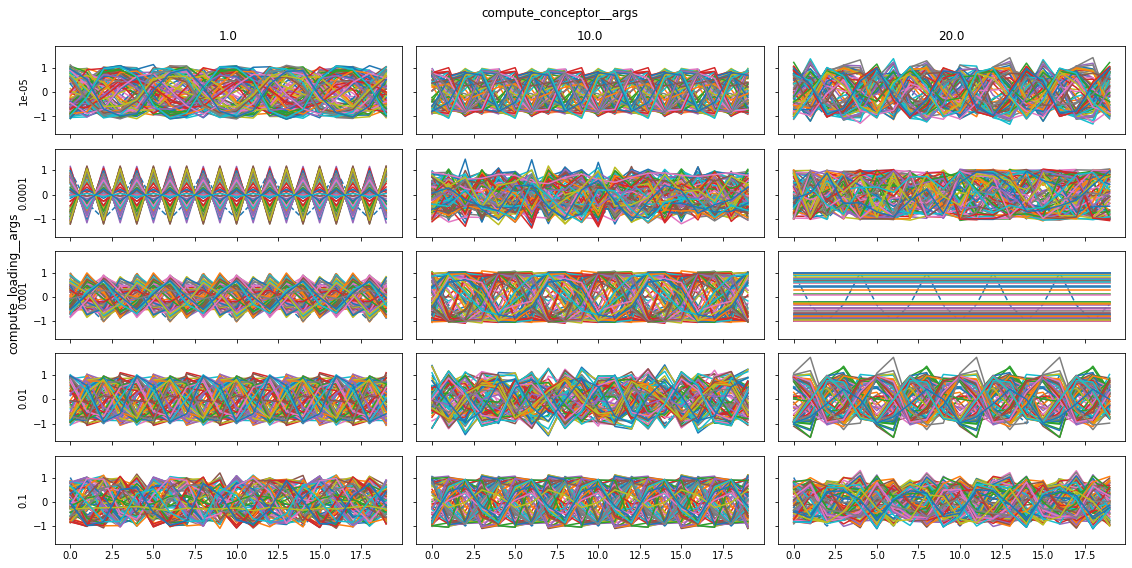

In [16]:
timeseriesPlot2d('compute_loading__args', 'compute_conceptor__args', figsize=(16, 8), data='xt_conceptor')

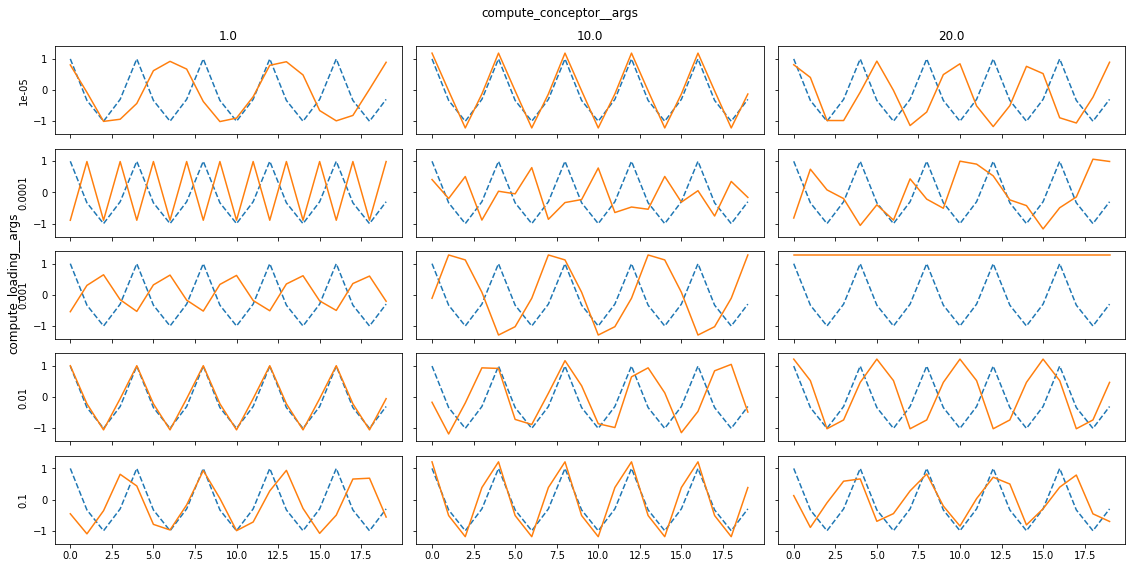

In [17]:
timeseriesPlot2d('compute_loading__args', 'compute_conceptor__args', figsize=(16, 8), data='yt_conceptor')

In [18]:
dropdown1 = widgets.Dropdown(
    options=hypers,
    value=hypers[0],
    description='Hyperparameter 1:',
    disabled=False,
)
dropdown2 = widgets.Dropdown(
    options=hypers,
    value=hypers[1],
    description='Hyperparameter 2:',
    disabled=False,
)

In [19]:
@interact(hyperparameter1=dropdown1, hyperparameter2=dropdown2)
def interactive_plot(hyperparameter1, hyperparameter2):
    timeseriesPlot2d(hyperparameter1, hyperparameter2, t_min=200, t_max=220, 
                data='yt_conceptor', figsize=(16, 8), esnBaseConfig=esnBaseConfig, 
                trainBaseConfig=trainBaseConfig, ut=ut, esnConfigs=esnConfigs, 
                trainingConfigs=trainingConfigs, configsList=configsList)

interactive(children=(Dropdown(description='Hyperparameter 1:', options=('spectral_radius', 'compute_conceptor…

## Performance comparison plot

**TODO**

Choose some hyperparameters (maximum 3) and show the space of hyperparameters where each experiment is shown as a point whose color (or coordinate) corresponds to its performance (as computed by some metric, to be decided).

## Single experiment time series plot

**TODO**